In [1]:
!python --version

Python 3.8.0


In [2]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

dice_demo_38


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np

# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Tensorflow import
import tensorflow as tf

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

# Load data

In [5]:
# dataset = helpers.load_adult_income_dataset()

In [6]:
dataset = pd.read_csv("marketing_campaign_lite.csv")

In [7]:
dataset.shape

(26048, 9)

In [19]:
dataset.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,response
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


# EDA

In [8]:
dataset.describe(include="all")

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,response
count,26048.00000,26048,26048,26048,26048,26048,26048,26048.000000,26048.000000
unique,NaN,4,8,5,6,2,2,NaN,NaN
top,NaN,Private,HS-grad,Married,Blue-Collar,White,Male,NaN,NaN
freq,NaN,18136,8401,12277,8048,22270,17403,NaN,NaN
mean,38.54246,NaN,NaN,NaN,NaN,NaN,NaN,40.456235,0.239097
std,13.64158,NaN,NaN,NaN,NaN,NaN,NaN,12.391435,0.426540
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
25%,28.00000,NaN,NaN,NaN,NaN,NaN,NaN,40.000000,0.000000
50%,37.00000,NaN,NaN,NaN,NaN,NaN,NaN,40.000000,0.000000
75%,48.00000,NaN,NaN,NaN,NaN,NaN,NaN,45.000000,0.000000


<AxesSubplot:xlabel='age', ylabel='Count'>

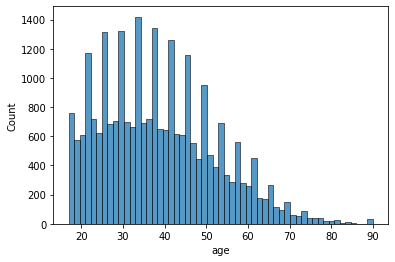

In [9]:
sns.histplot(dataset["age"])

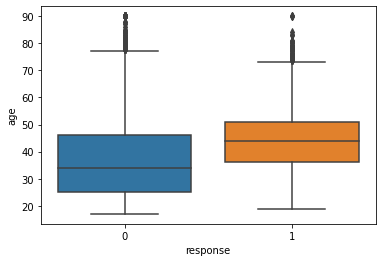

In [10]:
ax = sns.boxplot(x="response", y="age", data=dataset)

<AxesSubplot:xlabel='hours_per_week', ylabel='Count'>

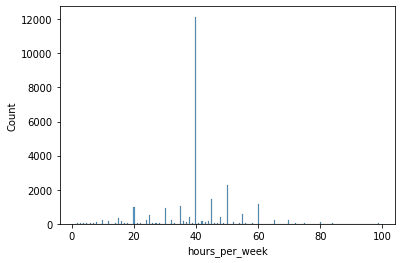

In [11]:
sns.histplot(dataset["hours_per_week"])

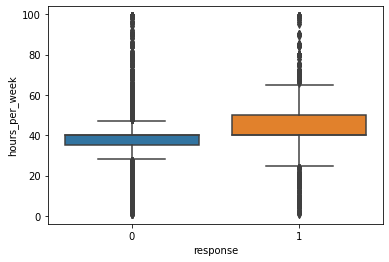

In [12]:
ax = sns.boxplot(x="response", y="hours_per_week", data=dataset)

In [13]:
for c in dataset.columns[1:7]:
    display(round(pd.crosstab(dataset["response"], dataset[c], normalize=1), 2))

workclass,Government,Other/Unknown,Private,Self-Employed
response,,,,
0,0.7,0.89,0.78,0.63
1,0.3,0.11,0.22,0.37


education,Assoc,Bachelors,Doctorate,HS-grad,Masters,Prof-school,School,Some-college
response,,,,,,,,
0,0.74,0.59,0.25,0.84,0.46,0.28,0.94,0.81
1,0.26,0.41,0.75,0.16,0.54,0.72,0.06,0.19


marital_status,Divorced,Married,Separated,Single,Widowed
response,,,,,
0,0.9,0.56,0.93,0.95,0.92
1,0.1,0.44,0.07,0.05,0.08


occupation,Blue-Collar,Other/Unknown,Professional,Sales,Service,White-Collar
response,,,,,,
0,0.83,0.89,0.56,0.74,0.87,0.68
1,0.17,0.11,0.44,0.26,0.13,0.32


race,Other,White
response,,
0,0.84,0.75
1,0.16,0.25


gender,Female,Male
response,,
0,0.89,0.7
1,0.11,0.3


# Modeling - RF, non-tuned

In [14]:
target = dataset["response"]
train_dataset, test_dataset, y_train, y_test = train_test_split(
    dataset, target, test_size=0.2,
    random_state=0, stratify=target)
X_train = train_dataset.drop('response', axis=1)
X_test = test_dataset.drop('response', axis=1)

In [15]:
numerical = ["age", "hours_per_week"]
categorical = X_train.columns.difference(numerical)

In [16]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical)])

In [17]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier(random_state=1))])
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['education', 'gender', 'marital_status', 'occupation', 'race',
       'workclass'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=1))])

In [18]:
X_train.head(1)

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week
20907,38,Private,HS-grad,Married,Blue-Collar,White,Male,44


In [19]:
clf.steps[0][1].get_feature_names_out()

array(['cat__education_Assoc', 'cat__education_Bachelors',
       'cat__education_Doctorate', 'cat__education_HS-grad',
       'cat__education_Masters', 'cat__education_Prof-school',
       'cat__education_School', 'cat__education_Some-college',
       'cat__gender_Female', 'cat__gender_Male',
       'cat__marital_status_Divorced', 'cat__marital_status_Married',
       'cat__marital_status_Separated', 'cat__marital_status_Single',
       'cat__marital_status_Widowed', 'cat__occupation_Blue-Collar',
       'cat__occupation_Other/Unknown', 'cat__occupation_Professional',
       'cat__occupation_Sales', 'cat__occupation_Service',
       'cat__occupation_White-Collar', 'cat__race_Other',
       'cat__race_White', 'cat__workclass_Government',
       'cat__workclass_Other/Unknown', 'cat__workclass_Private',
       'cat__workclass_Self-Employed'], dtype=object)

In [20]:
clf.steps[1][1].feature_importances_

array([0.01318324, 0.05180414, 0.02097486, 0.03970041, 0.0382752 ,
       0.02434078, 0.0533931 , 0.01993813, 0.03167366, 0.04086629,
       0.02497325, 0.28724946, 0.00780656, 0.1086478 , 0.0072762 ,
       0.04114872, 0.00522409, 0.04704776, 0.01167583, 0.01304054,
       0.03543006, 0.01254303, 0.01247302, 0.01303463, 0.0070134 ,
       0.01566272, 0.01560312])

In [21]:
print(f"AUC: {roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]):.3f}")

AUC: 0.859


# Counterfactuals by DiCE

In [22]:
d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=["age", "hours_per_week"],
                 outcome_name="response")

In [24]:
# Using sklearn backend
m = dice_ml.Model(model=clf, backend="sklearn")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

In [26]:
X_test[1:2]

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week
24228,50,Other/Unknown,Some-college,Married,Other/Unknown,White,Male,40


In [27]:
y_test[1:2]

24228    0
Name: response, dtype: int64

## Use case 1: Allowing to change any features

In [38]:
e1 = exp.generate_counterfactuals(X_test[1:2], total_CFs=5, desired_class="opposite",
                                  random_seed=1)
e1.visualize_as_dataframe(show_only_changes=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,response
0,50,Other/Unknown,Some-college,Married,Other/Unknown,White,Male,40,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,response
0,54.0,-,Doctorate,-,-,-,-,-,1
1,-,-,-,-,-,Other,-,55.0,1
2,-,Government,-,-,-,Other,-,-,1
3,-,-,-,-,-,Other,-,49.0,1
4,27.0,-,Doctorate,-,-,-,-,-,1


## Use case 2: Only vary the changeable features and give support in campaign planning

In [33]:
e2 = exp.generate_counterfactuals(X_test[14:15], total_CFs=3, desired_class="opposite",
                                  features_to_vary=["hours_per_week"], random_seed=1)
e2.visualize_as_dataframe(show_only_changes=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


UserConfigValidationException: No counterfactuals found for any of the query points! Kindly check your configuration.

In [35]:
e2 = exp.generate_counterfactuals(X_test[14:15], total_CFs=5, desired_class="opposite",
                                  features_to_vary=["marital_status", "hours_per_week"],
                                  random_seed=1)
e2.visualize_as_dataframe(show_only_changes=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,response
0,37,Private,Bachelors,Divorced,Service,White,Male,40,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,response
0,-,-,-,Married,-,-,-,78.0,1
1,-,-,-,Married,-,-,-,16.0,1
2,-,-,-,Married,-,-,-,62.0,1
3,-,-,-,Married,-,-,-,92.0,1
4,-,-,-,Married,-,-,-,87.0,1


In [37]:
e2 = exp.generate_counterfactuals(X_test[14:15], total_CFs=5, desired_class="opposite",
                                  features_to_vary=["marital_status", "occupation"],
                                  random_seed=1)
e2.visualize_as_dataframe(show_only_changes=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,response
0,37,Private,Bachelors,Divorced,Service,White,Male,40,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,response
0,-,-,-,Married,-,-,-,-,1
1,-,-,-,Married,Blue-Collar,-,-,-,1
2,-,-,-,Married,Other/Unknown,-,-,-,1
